In [44]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.set_option("display.max_rows", 30)
%matplotlib inline

def curve_fit(x, y, smoothness=.5):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    results = lowess(y, x, is_sorted=True, frac=smoothness)
    return results[:, 1]

In [51]:
def load_year(year):
    pxp = []
    files = glob.glob('Improved-NCAA-Football-Data/{}PXP/*.csv'.format(year))
    for file in files:
        plays = pd.read_csv(file)
        pxp.append(plays)
    pxp = pd.concat(pxp)
    
    pxp['half'] = pd.cut(pxp['quarter'], [1,2,4,11], labels=[1,2,3], include_lowest=True)
    pxp['yrdregion'] = pd.cut(pxp['yardLine'], [0., 9., 20., 100.], labels=['Inside10', '10to20', 'Beyond20'])
    ignore_plays = ['No Play', 'Timeout', 'Quarter End', 'End of Game', 'Coin Toss']
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline'] = game_halves['yardLine'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    
    return pxp

In [19]:
def extract_kickoffs_and_possessions(pxp):
    ko_mask = pxp['type'] == 'Kickoff'
    kickoffs = pxp.loc[ko_mask]
    
    xp_mask = pxp['type'].isin(['Extra Point'])
    game_drives = pxp.loc[~ko_mask & ~xp_mask].groupby(['gameId', 'driveIndex'])

    poss_starts = game_drives.head(1)

    ko_and_poss = pd.concat([kickoffs, poss_starts])\
            .sort_values(['gameId', 'driveIndex', 'down'], na_position='first')
    ko_and_poss.reset_index(drop=True, inplace=True)

    game_halves = ko_and_poss.groupby(['gameId', 'half'])
    score_change = -game_halves['homeScore'].diff(-1) + game_halves['awayScore'].diff(-1)
    ko_and_poss['NextScore'] = score_change.replace(to_replace=0., method='bfill').fillna(0)

    posteam = ko_and_poss['offenseTeam']
    hometeam = ko_and_poss['homeTeam']
    awayteam = ko_and_poss['awayTeam']
    posteam_is_home = (posteam == hometeam).astype(int)
    posteam_is_away = (posteam == awayteam).astype(int)
    ko_and_poss['PossessionValue'] = ko_and_poss['NextScore'] * \
        (posteam_is_home - posteam_is_away)

    first_and_third_qtr = (ko_and_poss['quarter'] == 1) | (ko_and_poss['quarter'] == 3)
    ko_and_poss_first_and_third = ko_and_poss.loc[first_and_third_qtr]

    return ko_and_poss_first_and_third

In [25]:
def extract_punts(pxp):
    punt_mask = pxp['type'] == 'Punt'
    punts = pxp.loc[punt_mask].copy()
    punts.reset_index(drop=True, inplace=True)

    posteam = punts['offenseTeam']
    nextposteam = punts['nextposteam']
    yrdline = punts['yardLine']
    nextyardline = punts['nextyrdline'] 

    poss_change = (posteam != nextposteam)
    net_punt_dist = (yrdline.astype(int) - (100 - nextyardline.astype(int))) * poss_change.astype(int)
    punts.loc[poss_change, 'net_punt_dist'] = net_punt_dist[poss_change]
    
    return punts

In [27]:
def extract_fgs(pxp):
    fg_mask = pxp['type'] == 'Field Goal'
    fgs = pxp.loc[fg_mask, ['FieldGoalDistance', 'FieldGoalResult']].copy()
    fgs['FieldGoalSuccess'] = (fgs['FieldGoalResult'] == 'Made').astype(int)
    return fgs

In [32]:
def extract_third_downs(pxp):
    ignore_plays = ['No Play', 'Timeout', 'Quarter End', 'End of Game', 'Punt', 'Field Goal', 'Kickoff']
    ignore_plays_mask = pxp['type'].isin(ignore_plays)
    all_third_downs_mask = (pxp['down'] == 3)
    under_10_to_go = (pxp['distance'] <= 9) & (pxp['distance'] >=0)
    third_down_mask = all_third_downs_mask & ~ignore_plays_mask & under_10_to_go

    third_down_plays = pxp.loc[third_down_mask].\
        copy().\
        reset_index(drop=True)
    return third_down_plays

In [52]:
pxp = []
ko_and_poss = []
punts = []
fgs = []
third_downs = []

for year in range(2001, 2018):
    pxp_year = load_year(year)
    ko_and_poss.append(extract_kickoffs_and_possessions(pxp_year))
    pxp.append(pxp_year)
    punts.append(extract_punts(pxp_year))
    fgs.append(extract_fgs(pxp_year))
    third_downs.append(extract_third_downs(pxp_year))

pxp = pd.concat(pxp)
ko_and_poss = pd.concat(ko_and_poss)
punts = pd.concat(punts)
fgs = pd.concat(fgs)
third_downs = pd.concat(third_downs)

In [53]:
ko_and_poss.info()
ko_and_poss

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213190 entries, 0 to 27984
Data columns (total 42 columns):
1stdownconversion    204172 non-null float64
ExPointResult        1 non-null object
FieldGoalDistance    80 non-null float64
FieldGoalResult      80 non-null object
NextScore            213190 non-null float64
PossessionValue      213190 non-null float64
Safety               213190 non-null int64
Touchdown            213190 non-null int64
awayAbbr             213190 non-null object
awayId               213190 non-null int64
awayScore            213190 non-null int64
awayTeam             213190 non-null object
clock                213190 non-null object
defenseAbbr          213190 non-null object
defenseId            213190 non-null int64
defenseTeam          213190 non-null object
description          213113 non-null object
distance             213190 non-null int64
down                 213190 non-null int64
driveIndex           213190 non-null int64
gameId               213190

,1stdownconversion,ExPointResult,FieldGoalDistance,FieldGoalResult,NextScore,PossessionValue,Safety,Touchdown,awayAbbr,awayId,...,offenseTeam,playIndex,quarter,type,wallclock,week,yardLine,yardsGained,year,yrdregion
0,1.0,NaN,NaN,NaN,0.0,0.0,0,0,UNC,153,...,Oklahoma,1,1,Kickoff,NaN,1,80,0,2001,Beyond20
1,0.0,NaN,NaN,NaN,0.0,-0.0,0,0,UNC,153,...,North Carolina,0,1,Rush,NaN,1,80,-3,2001,Beyond20
2,0.0,NaN,NaN,NaN,0.0,0.0,0,0,UNC,153,...,Oklahoma,0,1,Rush,NaN,1,13,-2,2001,10to20
3,1.0,NaN,NaN,NaN,-7.0,7.0,0,0,FRES,278,...,Fresno State,1,1,Kickoff,NaN,1,35,0,2001,Beyond20
4,0.0,NaN,NaN,NaN,-7.0,-7.0,0,0,FRES,278,...,Colorado,0,1,Rush,NaN,1,65,1,2001,Beyond20
5,1.0,NaN,NaN,NaN,-7.0,7.0,0,0,FRES,278,...,Fresno State,0,1,Pass,NaN,1,80,0,2001,Beyond20
6,1.0,NaN,NaN,NaN,-7.0,-7.0,0,0,FRES,278,...,Colorado,0,1,Rush,NaN,1,64,10,2001,Beyond20
7,0.0,NaN,NaN,NaN,-7.0,7.0,0,0,FRES,278,...,Fresno State,0,1,Pass,NaN,1,45,9,2001,Beyond20
8,1.0,NaN,NaN,NaN,-7.0,7.0,0,0,FRES,278,...,Fresno State,0,1,Kickoff,NaN,1,20,0,2001,10to20
9,0.0,NaN,NaN,NaN,-7.0,-7.0,0,0,FRES,278,...,Colorado,0,1,Pass,NaN,1,80,0,2001,Beyond20


In [54]:
ko = ko_and_poss['type'] == 'Kickoff'
ekv = ko_and_poss.loc[ko]['PossessionValue'].mean()
print("Expected Kickoff Value: {:.3f} pts".format(ekv))

Expected Kickoff Value: -1.906 pts


In [55]:
possession_values = ko_and_poss.loc[~ko].\
    groupby('yardLine')['PossessionValue'].\
    mean().\
    to_frame()
possession_values.columns = ['rEPV']
possession_values

,rEPV
yardLine,
0,0.607843
1,1.223881
2,3.157303
3,2.027972
4,2.460784
5,3.646552
6,3.222222
7,3.294737
8,3.292857


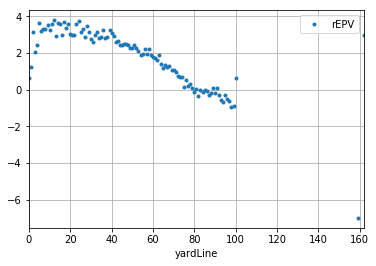

In [56]:
ax = possession_values.plot(y='rEPV', linestyle='', marker='.')
ax.grid()

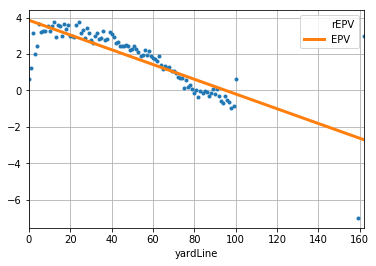

In [57]:
formula = 'rEPV ~ yardLine'
results = smf.ols(formula, data=possession_values.reset_index()).fit()

possession_values['EPV'] = results.fittedvalues.values
ax = possession_values.plot(y='rEPV', linestyle='', marker='.')
possession_values.plot(y='EPV', ax=ax, lw=3)
ax.grid()

epv_model = possession_values['EPV']

In [58]:
conv_pct = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    mean().\
    to_frame()
conv_pct.columns = ['rConvPct']  # update column names
conv_pct

rConvPct
yrdregion distance          
Inside10  0         0.948237
          1         0.637487
          2         0.513298
          3         0.425544
          4         0.380208
          5         0.335648
          6         0.294626
          7         0.294350
          8         0.256863
          9         0.219731
10to20    0         0.949732
          1         0.762327
          2         0.608864
          3         0.554415
          4         0.517536
          5         0.446888
          6         0.420426
          7         0.369048
          8         0.347445
          9         0.325634
Beyond20  0         0.917582
          1         0.753517
          2         0.624905
          3         0.559210
          4         0.530367
          5         0.481231
          6         0.443775
          7         0.411085
          8         0.378048
          9         0.359473

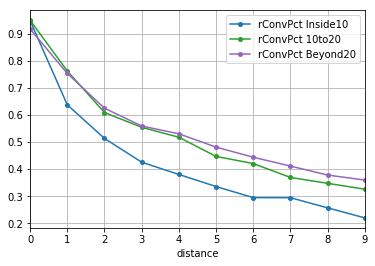

In [59]:
fig, ax = plt.subplots()
for color, region in [('C0', 'Inside10'), ('C2', '10to20'), ('C4', 'Beyond20')]:
    conv_pct.loc[region].plot(
        ax=ax, y='rConvPct', color=color, marker='.', ms=8, label='rConvPct ' + region)

ax.legend(loc=1)
ax.grid()

In [60]:
for region in ['Inside10', '10to20', 'Beyond20']:
    conv_pct_region = conv_pct.loc[region]
    conv_pct.loc[region, 'ExpConvPct'] = curve_fit(
        conv_pct_region.index, conv_pct_region['rConvPct'])
    
exp_conv_pct_model = conv_pct['ExpConvPct']

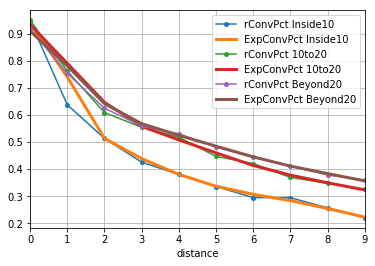

In [61]:
fig, ax = plt.subplots()
it = [(('C0', 'C1'), 'Inside10'), (('C2', 'C3'), '10to20'), (('C4', 'C5'), 'Beyond20')]
for (clr1, clr2), region in it:
    conv_pct.loc[region].plot(
        ax=ax, y='rConvPct', color=clr1, marker='.', ms=8, label='rConvPct ' + region)
    conv_pct.loc[region].plot(
        ax=ax, y='ExpConvPct', color=clr2, lw=3, label='ExpConvPct ' + region)

ax.legend(loc=1)
ax.grid()

In [62]:
punt_dist = punts.\
    groupby('yardLine')['net_punt_dist'].\
    mean().\
    to_frame()
punt_dist.columns = ['rExpNetPuntDist']  # Update column names
punt_dist

,rExpNetPuntDist
yardLine,
0,-24.500000
1,-36.000000
3,-9.000000
4,4.000000
5,-55.000000
6,6.000000
7,-25.000000
8,-63.000000
9,-37.000000


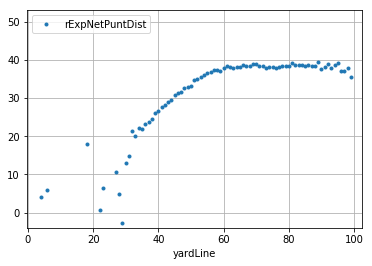

In [63]:
ax = punt_dist.plot(y='rExpNetPuntDist', linestyle='', marker='.')
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2)
ax.grid()

In [64]:
punt_dist['ExpNetPuntDist'] = curve_fit(
    punt_dist.index, punt_dist['rExpNetPuntDist'])

exp_net_punt_dist_model = punt_dist['ExpNetPuntDist']

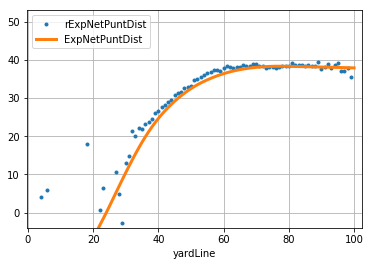

In [65]:
ax = punt_dist.plot(y='rExpNetPuntDist', linestyle='', marker='.')
punt_dist.plot(y='ExpNetPuntDist', ax=ax, lw=3)
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2)
ax.grid()

In [66]:
fg_prob = fgs.\
    groupby('FieldGoalDistance')['FieldGoalSuccess'].\
    mean().\
    to_frame()
fg_prob.columns = ['rFieldGoalProb']
fg_prob

,rFieldGoalProb
FieldGoalDistance,
0.0,0.800000
3.0,0.000000
10.0,0.500000
11.0,1.000000
15.0,0.500000
17.0,0.906250
18.0,0.958549
19.0,0.954741
20.0,0.937425


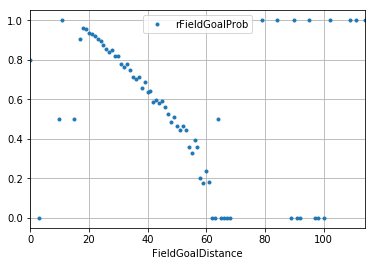

In [67]:
ax = fg_prob.plot(y='rFieldGoalProb', linestyle='', marker='.')
ax.legend(loc=0)
ax.grid()

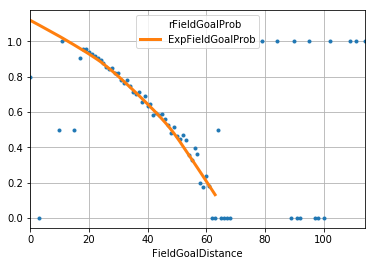

In [68]:
under_63_mask = fg_prob.index <= 63.
fg_under_63 = fg_prob.loc[under_63_mask]

fg_prob.loc[under_63_mask, 'ExpFieldGoalProb'] = curve_fit(
    fg_under_63.index, fg_under_63['rFieldGoalProb'])

exp_fg_prob_model = fg_prob.loc[under_63_mask, 'ExpFieldGoalProb'].copy()

ax = fg_prob.plot(y='rFieldGoalProb', linestyle='', marker='.')
fg_prob.plot(y='ExpFieldGoalProb', ax=ax, lw=3)
ax.grid()

In [69]:
print("EPV at 60 yards:", epv_model[60])
print("Exp Conv Pct inside the 10 with 1 yard to go: at", exp_conv_pct_model[('Inside10', 1)])
print("Exp Net Punt Dist from the 50:", exp_net_punt_dist_model[50])
print("Exp FG Pct from 45 yards:", exp_fg_prob_model[45])

EPV at 60 yards: 1.42893649866
Exp Conv Pct inside the 10 with 1 yard to go: at 0.740353132181
Exp Net Punt Dist from the 50: 32.4881805551
Exp FG Pct from 45 yards: 0.559131894348


In [70]:
epv_model

yardLine
0      3.859229
1      3.818725
2      3.778220
3      3.737715
4      3.697210
5      3.656705
6      3.616200
7      3.575695
8      3.535190
9      3.494686
10     3.454181
11     3.413676
12     3.373171
13     3.332666
14     3.292161
         ...   
88     0.294800
89     0.254295
90     0.213790
91     0.173285
92     0.132780
93     0.092275
94     0.051770
95     0.011266
96    -0.029239
97    -0.069744
98    -0.110249
99    -0.150754
100   -0.191259
159   -2.581047
162   -2.702562
Name: EPV, Length: 103, dtype: float64

In [71]:
def build_decision_maker(ekv, epv_model, exp_conv_pct_model, 
                         exp_net_punt_dist_model, exp_fg_prob_model):
    
    YRDSTOGO_CAP = 10  # Model restriction
    PUNT_LIM = 29      # Model restriction
    FG_LIM = 63        # Model restriction
    FG_OFFSET = 8      # Field goal placement distance (not including the 10 for the endzone)
    FG_FAIL_RESET = 0  # Where the ball is placed after a failed field goal.  If 0, at the spot.  
                       # Otherwise, at the spot or at the reset spot, whichever is better.
    
    def decision_maker(yrdline100, ydstogo, print_message=False):
        if yrdline100 < 10:
            region = 'Inside10'
        elif yrdline100 < 20:
            region = '10to20'
        else:
            region = 'Beyond20'
            
        # 1. Expected value of going for it
        
        # Value of failing (approximately turning over at same spot)
        conv_fail_yrdline100 = 100 - yrdline100
        conv_fail_epv = -epv_model[conv_fail_yrdline100] 
        
        # Value of converting (approximately at the first down marker)
        if yrdline100 == ydstogo:
            conv_succ_epv = 7 - ekv
        else:
            first_down_yrdline100 = yrdline100 - ydstogo
            conv_succ_epv = epv_model[first_down_yrdline100]

        # Conversion Pct
        exp_conv_pct = exp_conv_pct_model[(region, ydstogo)] if ydstogo < YRDSTOGO_CAP else None
        
        # Overall expected value of going for it
        go_ev = exp_conv_pct * conv_succ_epv + (1 - exp_conv_pct) * conv_fail_epv
        
        # 2. Expected value of punting
        
        # Expected next yardline
        if yrdline100 >= PUNT_LIM:
            exp_net_punt_dist = exp_net_punt_dist_model[yrdline100]
            exp_yrdline100 = 100 - yrdline100 + int(exp_net_punt_dist)
            
            # Overall expected value of punting
            punt_ev = -epv_model[exp_yrdline100]
        else:
            punt_ev = None
            
        # 3. Expected value of kicking a field goal
        fg_dist =  yrdline100 + 10 + FG_OFFSET
        if fg_dist <= FG_LIM:
            # Probability of success
            exp_fg_prob = exp_fg_prob_model[fg_dist ]

            # Expected value of field success
            fg_succ_epv = 3 - ekv

            # EPV of field goal fail
            fg_fail_yrdline100 = 100 - yrdline100 - FG_OFFSET
            fg_fail_epv = -epv_model[fg_fail_yrdline100]

            # Overall expected value kicking
            fg_ev = fg_succ_epv * exp_fg_prob + fg_fail_epv * (1 - exp_fg_prob)
        else:
            fg_ev = None
    
        choices = [('go for it', go_ev), ('punt', punt_ev), ('kick', fg_ev)]
        max_val = -100
        for choice, ev in choices:
            if ev is None:
                continue
            if ev > max_val:
                max_val = ev
                decision = choice
    
        if print_message:
            print("Expected Values")
            print("Go for it: {:.2f}".format(go_ev))
            if punt_ev is not None:
                print("Punt: {:.2f}".format(punt_ev))
            else:
                print("Punt: TOO CLOSE TO PUNT")
            if fg_ev is not None:
                print("FG: {:.2f}".format(fg_ev))
            else:
                print("FG: TOO FAR TO KICK")        

            print()
            print("Coach, you should:")
            print(decision.upper())

        return decision
    
    return decision_maker

# Build the decision maker
decision_maker = build_decision_maker(
    ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model, exp_fg_prob_model)

In [72]:
decision_maker(70, 4, print_message=True);

Expected Values
Go for it: -0.63
Punt: -1.10
FG: TOO FAR TO KICK

Coach, you should:
GO FOR IT


In [73]:
# Determine the decisions for each combination on the field

yrdlines = list(range(1, 100))
down_dist = list(range(1, 10))

decisions = []
for yrdstogo in down_dist:
    tmp = []
    for yrdline in yrdlines:
        if (yrdline >= yrdstogo) and (100 - yrdline + yrdstogo >= 10): # Exclude impossible scenarios
            decision = decision_maker(yrdline, yrdstogo)
            tmp.append(decision)
        else:
            tmp.append(None)
    decisions.append(tmp)
# Convert to a table
pd.DataFrame(decisions, columns=yrdlines, index=down_dist)

,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
1,go for it,kick,kick,kick,kick,kick,kick,kick,kick,kick,...,go for it,go for it,None,None,None,None,None,None,None,None
2,None,go for it,kick,kick,kick,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,None,None,None,None,None,None,None
3,None,None,kick,kick,kick,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,None,None,None,None,None,None
4,None,None,None,kick,kick,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,go for it,None,None,None,None,None
5,None,None,None,None,kick,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,go for it,go for it,None,None,None,None
6,None,None,None,None,None,kick,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,go for it,go for it,go for it,None,None,None
7,None,None,None,None,None,None,kick,kick,kick,kick,...,go for it,go for it,go for it,go for it,go for it,go for it,go for it,go for it,None,None
8,None,None,None,None,None,None,None,kick,kick,kick,...,punt,punt,punt,punt,punt,punt,punt,go for it,go for it,None
9,None,None,None,None,None,None,None,None,kick,kick,...,punt,punt,punt,punt,punt,punt,punt,punt,punt,punt


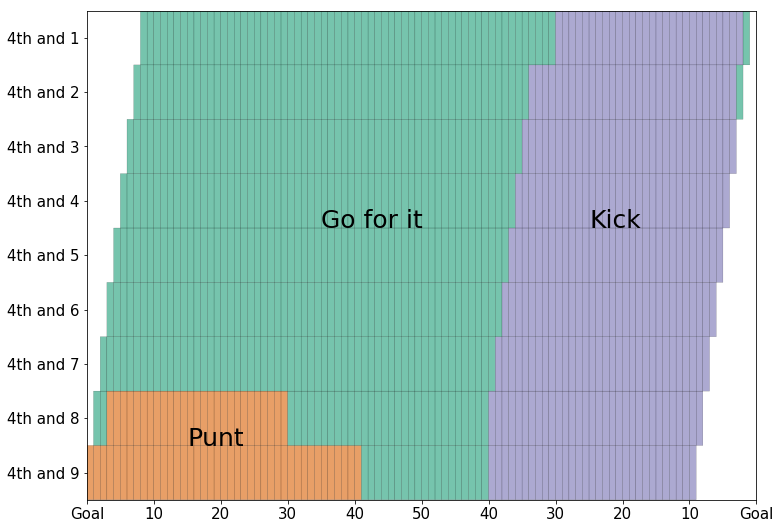

In [85]:
import numpy as np
data = np.zeros((9, 99))
for i in range(9):
    for j in range(99):
        decision = decisions[i][j]
        if decision == 'go for it':
            val = 1
        elif decision == 'punt':
            val = 2
        elif decision == 'kick':
            val = 3
        elif decision is None:
            val = np.nan
        data[i, j] = val
data = data[::-1,::-1]

fig, ax = plt.subplots(figsize=(12, 9))

ax.pcolor(
    data,
    vmin=1,
    vmax=8,
    edgecolors='k', 
    linewidths=.2,
    cmap=plt.get_cmap('Dark2'),
    alpha=.6
);
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(['Goal', '10', '20', '30', '40', '50', '40', '30', '20', '10', 'Goal'])
ax.set_yticks([
    yd - .5
    for yd in range(1, 10)
])
ax.set_yticklabels([
    '4th and {}'.format(yd)
    for yd in range(9, 0, -1)
])
ax.text(35, 5, 'Go for it', size=25)
ax.text(15, 1, 'Punt', size=25)
ax.text(75, 5, 'Kick', size=25)
ax.tick_params(axis='both', which='major', labelsize=15);